# Project 1 in course 02463

## Implementing Bayesian optimization for a CNN as a means to find optimal hyperparameters

### The code for the CNN was heavily inspired by the following kaggle article:
#### https://www.kaggle.com/mirhyun0508/2022-smarcle-ai-fashion-mnist-cnn



### Import dependencies

In [1]:
import sys
import os

from tensorflow import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential

import GPyOpt

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [2]:
train = pd.read_csv('Data/fashion-mnist_train.csv')
test = pd.read_csv('Data/fashion-mnist_test.csv')

class_names = train.columns

In [3]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [4]:
n_classes = 10
train_size = 600
test_size = 100

X_train = train.drop(["label"], axis=1)
y_train = train["label"]

X_test = test.drop(["label"], axis=1)
y_test = test["label"]

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

where_train = []
where_test = []

for label in range(n_classes):
    where_train.append(np.where(y_train == label)[0][:round(train_size/10)])
    where_test.append(np.where(y_test == label)[0][:round(test_size/10)])

where_train = np.array(where_train).flatten()
where_test = np.array(where_test).flatten()

X_train = X_train[where_train]
y_train = y_train[where_train]

X_test = X_test[where_test]
y_test = y_test[where_test]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

(600, 784)
(600,)
(100, 784)
(100,)


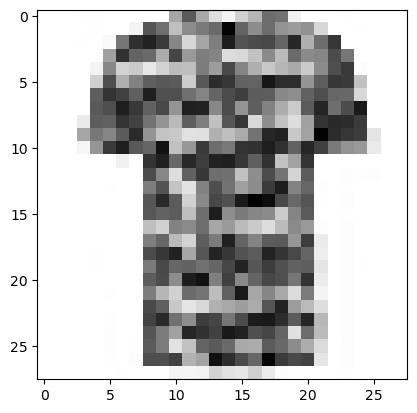

In [6]:
# Display an image
plt.imshow(X_train[0], cmap='Greys')
plt.show()

In [5]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### Defining CNN class

In [6]:
class CNN:
    def __init__(self, X_train, y_train, X_test, y_test):
        #self.n_epochs = n_epochs
        #self.kernel_size = kernel_size
        #self.learning_rate = learning_rate
        #self.batch_size = batch_size
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        
        
    def CNNModelTrain(self, kernel_size, learning_rate, summary = False):
        
        # The model is created
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size) , input_shape = (28, 28, 1), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
        
        # Display model summary if true
        if summary == True:
            model.summary()
        
        # Train the model
        #MODEL_DIR = './model/'
        #if not os.path.exists(MODEL_DIR):
        #  os.mkdir(MODEL_DIR)

        #modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
        #checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
        #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
        
        history = model.fit(X_train, y_train, 
        validation_data=(X_test, y_test), epochs=10,batch_size=300, 
        verbose=1)
        #callbacks=[early_stopping_callback, checkpointer])
        
        accuracies = history.history['val_accuracy']
        return history, accuracies[-1]
    
    
    def plotResults(self, history):
        y_vacc = history.history['val_accuracy']

        y_acc = history.history['accuracy']


        x_len = np.arange(1,len(y_acc)+1, 1)
        plt.plot(x_len, y_vacc, marker='.', c='red', label='Testset_accuracy')
        plt.plot(x_len, y_acc, marker='.', c='blue', label='Trainset_accuracy')


        plt.legend(loc='upper right')
        plt.grid()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    
        
        

### Create a model and train with fixed hyperparameters (deliberately bad)
#### The train-test dynamics are illustrated
##### Train and test accuracy is also visualized below

Model: "sequential_364"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_728 (Conv2D)         (None, 24, 24, 32)        832       
                                                                 
 conv2d_729 (Conv2D)         (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_364 (MaxPooli  (None, 11, 11, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_728 (Dropout)       (None, 11, 11, 64)        0         
                                                                 
 flatten_364 (Flatten)       (None, 7744)              0         
                                                                 
 dense_728 (Dense)           (None, 128)               991360    
                                                    

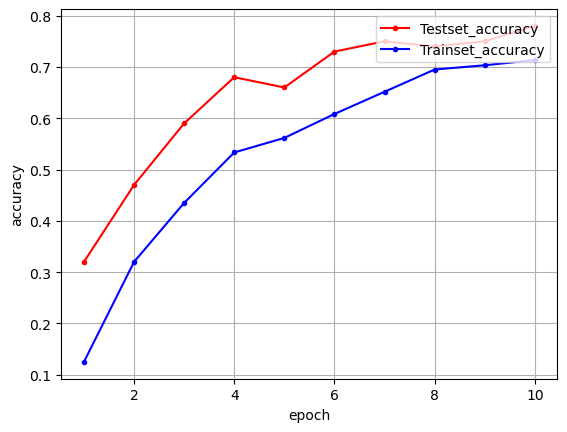

Accuracy at the last epoch: 0.7799999713897705
Loss at the last epoch: 0.680195689201355


In [25]:
# If you want the model to perform well set lr = 0.001 and k = 3.

# Keep these values fixed if you want a decent but improvable result:
## e = 5, lr = 0.05, k = 5, b = 400
e = 20
lr = 0.001
k = 5
b = 100


m = CNN(X_train = X_train, y_train = y_train, X_test = X_test,y_test = y_test)
# Create a CNN model
hist, final_acc = m.CNNModelTrain(kernel_size = k, learning_rate = lr,summary = True)


m.plotResults(hist)


final_loss = hist.history['val_loss'][-1]
print("Accuracy at the last epoch:", final_acc)
print("Loss at the last epoch:", final_loss)

## Implementing Exhaustive Search for finding the optimal hyperparameters

### Hyperparameters are defined:

In [7]:
# Kernel sizes
kernel_sizes = tuple(np.arange(1,8,1, dtype = np.int64))
# Learning rate:
lr = tuple(np.arange(0.001, 0.0201, 0.001, dtype = np.float64))

print(kernel_sizes)
print(lr)

for l in lr:
    print(l)

(1, 2, 3, 4, 5, 6, 7)
(0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002, 0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019000000000000003, 0.02)
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009000000000000001
0.010000000000000002
0.011
0.012
0.013000000000000001
0.014000000000000002
0.015
0.016
0.017
0.018000000000000002
0.019000000000000003
0.02


In [8]:
# Record the time taken until convergence
start = timer()

final_losses = list()
final_accs = list()

optimal_hyperparams = [0,0]
best_acc = 0

for k in kernel_sizes:
    for l in lr:
        print(k,l)
        m = CNN(X_train = X_train, y_train = y_train, X_test = X_test,y_test = y_test)

        # Create CNN model and train it
        hist, acc = m.CNNModelTrain(kernel_size = k, learning_rate = l, summary = False)

        final_losses.append(hist.history['val_loss'][-1])
        final_accs.append(acc)

        if max(final_accs) > best_acc:
            best_acc = max(final_accs)
            optimal_hyperparams = [k, l]

end = timer()
print("The best accuracy was:", max(final_accs))
print("-------------------------------------------")
print("The best hyperparameters were found to be:")
print("Kernel size:", optimal_hyperparams[0])
print("Learning rate:", optimal_hyperparams[1])

print("It took", end-start, "time until convergence")


1 0.001
Epoch 1/10
2/2 [==============================] - 1s 395ms/step - loss: 2.2175 - accuracy: 0.1767 - val_loss: 1.8290 - val_accuracy: 0.3300
Epoch 2/10
2/2 [==============================] - 0s 241ms/step - loss: 1.7397 - accuracy: 0.4283 - val_loss: 1.2350 - val_accuracy: 0.6400
Epoch 3/10
2/2 [==============================] - 0s 215ms/step - loss: 1.3545 - accuracy: 0.5250 - val_loss: 0.8937 - val_accuracy: 0.7400
Epoch 4/10
2/2 [==============================] - 0s 220ms/step - loss: 1.1913 - accuracy: 0.5650 - val_loss: 0.7416 - val_accuracy: 0.8000
Epoch 5/10
2/2 [==============================] - 0s 217ms/step - loss: 1.0497 - accuracy: 0.6267 - val_loss: 0.6956 - val_accuracy: 0.7500
Epoch 6/10
2/2 [==============================] - 0s 214ms/step - loss: 0.9413 - accuracy: 0.6900 - val_loss: 0.6745 - val_accuracy: 0.7300
Epoch 7/10
2/2 [==============================] - 0s 217ms/step - loss: 0.8168 - accuracy: 0.7100 - val_loss: 0.6576 - val_accuracy: 0.7700
Epoch 8/10
2

2/2 [==============================] - 0s 256ms/step - loss: 0.5494 - accuracy: 0.8100 - val_loss: 0.4907 - val_accuracy: 0.8300
Epoch 10/10
2/2 [==============================] - 0s 207ms/step - loss: 0.5074 - accuracy: 0.8267 - val_loss: 0.5109 - val_accuracy: 0.8700
1 0.007
Epoch 1/10
2/2 [==============================] - 1s 447ms/step - loss: 2.8186 - accuracy: 0.1317 - val_loss: 1.8873 - val_accuracy: 0.4600
Epoch 2/10
2/2 [==============================] - 0s 258ms/step - loss: 1.9281 - accuracy: 0.4233 - val_loss: 1.4427 - val_accuracy: 0.6300
Epoch 3/10
2/2 [==============================] - 0s 233ms/step - loss: 1.4553 - accuracy: 0.5350 - val_loss: 0.9160 - val_accuracy: 0.6700
Epoch 4/10
2/2 [==============================] - 0s 215ms/step - loss: 1.0655 - accuracy: 0.6483 - val_loss: 0.6265 - val_accuracy: 0.7900
Epoch 5/10
2/2 [==============================] - 0s 225ms/step - loss: 0.8744 - accuracy: 0.7117 - val_loss: 0.5584 - val_accuracy: 0.7700
Epoch 6/10
2/2 [======

Epoch 7/10
2/2 [==============================] - 1s 281ms/step - loss: 0.6872 - accuracy: 0.7733 - val_loss: 0.4867 - val_accuracy: 0.7900
Epoch 8/10
2/2 [==============================] - 1s 293ms/step - loss: 0.6406 - accuracy: 0.7667 - val_loss: 0.4650 - val_accuracy: 0.8900
Epoch 9/10
2/2 [==============================] - 1s 285ms/step - loss: 0.5604 - accuracy: 0.8033 - val_loss: 0.4658 - val_accuracy: 0.8700
Epoch 10/10
2/2 [==============================] - 1s 284ms/step - loss: 0.4828 - accuracy: 0.8233 - val_loss: 0.4843 - val_accuracy: 0.8300
1 0.013000000000000001
Epoch 1/10
2/2 [==============================] - 1s 552ms/step - loss: 3.4458 - accuracy: 0.1450 - val_loss: 3.1701 - val_accuracy: 0.2600
Epoch 2/10
2/2 [==============================] - 0s 276ms/step - loss: 2.9784 - accuracy: 0.3317 - val_loss: 1.9059 - val_accuracy: 0.5100
Epoch 3/10
2/2 [==============================] - 1s 277ms/step - loss: 1.8713 - accuracy: 0.4350 - val_loss: 1.2907 - val_accuracy: 0.6

Epoch 5/10
2/2 [==============================] - 1s 297ms/step - loss: 0.8621 - accuracy: 0.6900 - val_loss: 0.5390 - val_accuracy: 0.7900
Epoch 6/10
2/2 [==============================] - 1s 297ms/step - loss: 0.6623 - accuracy: 0.7617 - val_loss: 0.5187 - val_accuracy: 0.7800
Epoch 7/10
2/2 [==============================] - 1s 300ms/step - loss: 0.6014 - accuracy: 0.7933 - val_loss: 0.5126 - val_accuracy: 0.7600
Epoch 8/10
2/2 [==============================] - 1s 298ms/step - loss: 0.5399 - accuracy: 0.8017 - val_loss: 0.5664 - val_accuracy: 0.8200
Epoch 9/10
2/2 [==============================] - 1s 298ms/step - loss: 0.4202 - accuracy: 0.8717 - val_loss: 0.6451 - val_accuracy: 0.8300
Epoch 10/10
2/2 [==============================] - 1s 306ms/step - loss: 0.3654 - accuracy: 0.8767 - val_loss: 0.6713 - val_accuracy: 0.8400
1 0.019000000000000003
Epoch 1/10
2/2 [==============================] - 1s 483ms/step - loss: 5.6285 - accuracy: 0.1717 - val_loss: 2.9248 - val_accuracy: 0.3

2/2 [==============================] - 1s 299ms/step - loss: 1.2900 - accuracy: 0.5650 - val_loss: 0.7427 - val_accuracy: 0.7300
Epoch 4/10
2/2 [==============================] - 1s 289ms/step - loss: 1.0191 - accuracy: 0.6450 - val_loss: 0.6029 - val_accuracy: 0.8000
Epoch 5/10
2/2 [==============================] - 1s 288ms/step - loss: 0.8966 - accuracy: 0.6833 - val_loss: 0.5765 - val_accuracy: 0.7900
Epoch 6/10
2/2 [==============================] - 1s 297ms/step - loss: 0.7661 - accuracy: 0.7350 - val_loss: 0.5514 - val_accuracy: 0.8400
Epoch 7/10
2/2 [==============================] - 1s 288ms/step - loss: 0.6865 - accuracy: 0.7517 - val_loss: 0.5492 - val_accuracy: 0.8100
Epoch 8/10
2/2 [==============================] - 1s 288ms/step - loss: 0.6117 - accuracy: 0.7917 - val_loss: 0.5228 - val_accuracy: 0.8000
Epoch 9/10
2/2 [==============================] - 1s 301ms/step - loss: 0.5609 - accuracy: 0.8067 - val_loss: 0.5077 - val_accuracy: 0.8300
Epoch 10/10
2/2 [==============

2/2 [==============================] - 1s 436ms/step - loss: 2.8575 - accuracy: 0.1333 - val_loss: 2.3733 - val_accuracy: 0.2300
Epoch 2/10
2/2 [==============================] - 1s 289ms/step - loss: 2.2227 - accuracy: 0.3200 - val_loss: 1.8120 - val_accuracy: 0.5500
Epoch 3/10
2/2 [==============================] - 1s 305ms/step - loss: 1.7202 - accuracy: 0.4783 - val_loss: 1.1352 - val_accuracy: 0.6400
Epoch 4/10
2/2 [==============================] - 1s 331ms/step - loss: 1.1707 - accuracy: 0.5950 - val_loss: 0.7321 - val_accuracy: 0.7300
Epoch 5/10
2/2 [==============================] - 1s 277ms/step - loss: 0.9704 - accuracy: 0.6817 - val_loss: 0.6081 - val_accuracy: 0.7200
Epoch 6/10
2/2 [==============================] - 1s 277ms/step - loss: 0.8078 - accuracy: 0.7050 - val_loss: 0.5446 - val_accuracy: 0.7400
Epoch 7/10
2/2 [==============================] - 1s 287ms/step - loss: 0.6786 - accuracy: 0.7667 - val_loss: 0.5140 - val_accuracy: 0.7500
Epoch 8/10
2/2 [===============

2/2 [==============================] - 1s 308ms/step - loss: 0.5737 - accuracy: 0.7967 - val_loss: 0.4849 - val_accuracy: 0.8100
Epoch 10/10
2/2 [==============================] - 1s 282ms/step - loss: 0.4914 - accuracy: 0.8317 - val_loss: 0.4514 - val_accuracy: 0.8400
2 0.016
Epoch 1/10
2/2 [==============================] - 1s 498ms/step - loss: 5.0028 - accuracy: 0.1267 - val_loss: 6.8593 - val_accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 1s 303ms/step - loss: 5.1185 - accuracy: 0.1600 - val_loss: 2.1205 - val_accuracy: 0.5100
Epoch 3/10
2/2 [==============================] - 1s 333ms/step - loss: 2.0792 - accuracy: 0.4483 - val_loss: 1.7339 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 1s 355ms/step - loss: 1.6779 - accuracy: 0.4533 - val_loss: 1.0747 - val_accuracy: 0.6200
Epoch 5/10
2/2 [==============================] - 1s 349ms/step - loss: 1.1934 - accuracy: 0.5733 - val_loss: 0.7037 - val_accuracy: 0.7400
Epoch 6/10
2/2 [======

Epoch 7/10
2/2 [==============================] - 1s 286ms/step - loss: 0.9913 - accuracy: 0.6483 - val_loss: 0.6663 - val_accuracy: 0.7600
Epoch 8/10
2/2 [==============================] - 1s 309ms/step - loss: 0.9059 - accuracy: 0.7100 - val_loss: 0.6382 - val_accuracy: 0.7500
Epoch 9/10
2/2 [==============================] - 1s 288ms/step - loss: 0.8805 - accuracy: 0.6883 - val_loss: 0.6502 - val_accuracy: 0.7400
Epoch 10/10
2/2 [==============================] - 1s 291ms/step - loss: 0.7680 - accuracy: 0.7483 - val_loss: 0.6411 - val_accuracy: 0.7900
3 0.002
Epoch 1/10
2/2 [==============================] - 1s 477ms/step - loss: 2.2741 - accuracy: 0.1133 - val_loss: 1.9244 - val_accuracy: 0.4500
Epoch 2/10
2/2 [==============================] - 1s 323ms/step - loss: 1.8566 - accuracy: 0.4417 - val_loss: 1.2882 - val_accuracy: 0.6100
Epoch 3/10
2/2 [==============================] - 1s 304ms/step - loss: 1.4168 - accuracy: 0.4900 - val_loss: 0.8763 - val_accuracy: 0.6500
Epoch 4/10


2/2 [==============================] - 1s 278ms/step - loss: 0.8804 - accuracy: 0.7167 - val_loss: 0.6153 - val_accuracy: 0.8200
Epoch 6/10
2/2 [==============================] - 1s 298ms/step - loss: 0.7437 - accuracy: 0.7583 - val_loss: 0.5620 - val_accuracy: 0.7700
Epoch 7/10
2/2 [==============================] - 1s 290ms/step - loss: 0.6631 - accuracy: 0.7633 - val_loss: 0.5085 - val_accuracy: 0.8200
Epoch 8/10
2/2 [==============================] - 1s 286ms/step - loss: 0.6091 - accuracy: 0.7817 - val_loss: 0.5120 - val_accuracy: 0.8500
Epoch 9/10
2/2 [==============================] - 1s 285ms/step - loss: 0.5368 - accuracy: 0.8050 - val_loss: 0.5014 - val_accuracy: 0.8100
Epoch 10/10
2/2 [==============================] - 1s 307ms/step - loss: 0.4695 - accuracy: 0.8500 - val_loss: 0.4504 - val_accuracy: 0.8100
3 0.008
Epoch 1/10
2/2 [==============================] - 1s 446ms/step - loss: 2.6760 - accuracy: 0.1167 - val_loss: 2.2771 - val_accuracy: 0.4000
Epoch 2/10
2/2 [======

Epoch 3/10
2/2 [==============================] - 1s 283ms/step - loss: 1.6467 - accuracy: 0.5683 - val_loss: 0.9384 - val_accuracy: 0.7000
Epoch 4/10
2/2 [==============================] - 0s 277ms/step - loss: 1.1172 - accuracy: 0.6150 - val_loss: 0.6252 - val_accuracy: 0.7700
Epoch 5/10
2/2 [==============================] - 1s 306ms/step - loss: 0.8989 - accuracy: 0.6783 - val_loss: 0.5700 - val_accuracy: 0.7700
Epoch 6/10
2/2 [==============================] - 1s 279ms/step - loss: 0.7618 - accuracy: 0.7217 - val_loss: 0.5360 - val_accuracy: 0.7900
Epoch 7/10
2/2 [==============================] - 1s 314ms/step - loss: 0.7166 - accuracy: 0.7567 - val_loss: 0.5231 - val_accuracy: 0.7700
Epoch 8/10
2/2 [==============================] - 1s 300ms/step - loss: 0.6014 - accuracy: 0.7700 - val_loss: 0.5065 - val_accuracy: 0.7700
Epoch 9/10
2/2 [==============================] - 1s 295ms/step - loss: 0.5208 - accuracy: 0.8083 - val_loss: 0.4731 - val_accuracy: 0.8000
Epoch 10/10
2/2 [===

3 0.019000000000000003
Epoch 1/10
2/2 [==============================] - 1s 435ms/step - loss: 5.5587 - accuracy: 0.0750 - val_loss: 2.9181 - val_accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 279ms/step - loss: 2.7791 - accuracy: 0.1350 - val_loss: 2.1879 - val_accuracy: 0.1800
Epoch 3/10
2/2 [==============================] - 1s 300ms/step - loss: 2.1977 - accuracy: 0.2017 - val_loss: 1.8737 - val_accuracy: 0.4900
Epoch 4/10
2/2 [==============================] - 1s 292ms/step - loss: 1.7972 - accuracy: 0.4267 - val_loss: 1.1433 - val_accuracy: 0.7100
Epoch 5/10
2/2 [==============================] - 1s 305ms/step - loss: 1.4901 - accuracy: 0.4700 - val_loss: 0.8050 - val_accuracy: 0.7600
Epoch 6/10
2/2 [==============================] - 1s 290ms/step - loss: 1.1592 - accuracy: 0.6017 - val_loss: 0.7643 - val_accuracy: 0.7700
Epoch 7/10
2/2 [==============================] - 1s 292ms/step - loss: 1.0301 - accuracy: 0.6483 - val_loss: 0.6332 - val_accuracy: 0.79

2/2 [==============================] - 1s 285ms/step - loss: 0.6438 - accuracy: 0.7700 - val_loss: 0.5450 - val_accuracy: 0.8000
Epoch 10/10
2/2 [==============================] - 1s 285ms/step - loss: 0.5749 - accuracy: 0.7950 - val_loss: 0.4935 - val_accuracy: 0.8100
4 0.005
Epoch 1/10
2/2 [==============================] - 1s 441ms/step - loss: 2.2342 - accuracy: 0.2033 - val_loss: 1.6964 - val_accuracy: 0.4900
Epoch 2/10
2/2 [==============================] - 0s 271ms/step - loss: 1.6890 - accuracy: 0.3900 - val_loss: 1.0996 - val_accuracy: 0.6700
Epoch 3/10
2/2 [==============================] - 1s 274ms/step - loss: 1.2333 - accuracy: 0.5483 - val_loss: 0.7519 - val_accuracy: 0.7100
Epoch 4/10
2/2 [==============================] - 1s 278ms/step - loss: 0.9413 - accuracy: 0.6500 - val_loss: 0.6975 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 0s 276ms/step - loss: 0.7939 - accuracy: 0.7183 - val_loss: 0.5965 - val_accuracy: 0.7700
Epoch 6/10
2/2 [======

Epoch 7/10
2/2 [==============================] - 1s 281ms/step - loss: 0.9097 - accuracy: 0.6800 - val_loss: 0.7020 - val_accuracy: 0.7300
Epoch 8/10
2/2 [==============================] - 1s 279ms/step - loss: 0.7435 - accuracy: 0.7150 - val_loss: 0.6315 - val_accuracy: 0.8400
Epoch 9/10
2/2 [==============================] - 1s 290ms/step - loss: 0.6712 - accuracy: 0.7317 - val_loss: 0.5385 - val_accuracy: 0.8300
Epoch 10/10
2/2 [==============================] - 1s 343ms/step - loss: 0.6113 - accuracy: 0.7967 - val_loss: 0.4937 - val_accuracy: 0.8000
4 0.011
Epoch 1/10
2/2 [==============================] - 2s 589ms/step - loss: 5.0436 - accuracy: 0.1250 - val_loss: 2.4508 - val_accuracy: 0.3400
Epoch 2/10
2/2 [==============================] - 1s 340ms/step - loss: 2.4361 - accuracy: 0.2483 - val_loss: 2.0077 - val_accuracy: 0.2600
Epoch 3/10
2/2 [==============================] - 1s 372ms/step - loss: 1.9494 - accuracy: 0.3300 - val_loss: 1.3570 - val_accuracy: 0.5800
Epoch 4/10


Epoch 5/10
2/2 [==============================] - 1s 281ms/step - loss: 0.9746 - accuracy: 0.6783 - val_loss: 0.6736 - val_accuracy: 0.7300
Epoch 6/10
2/2 [==============================] - 0s 274ms/step - loss: 0.8962 - accuracy: 0.6850 - val_loss: 0.6507 - val_accuracy: 0.7500
Epoch 7/10
2/2 [==============================] - 0s 267ms/step - loss: 0.7807 - accuracy: 0.7167 - val_loss: 0.5491 - val_accuracy: 0.7800
Epoch 8/10
2/2 [==============================] - 0s 268ms/step - loss: 0.6833 - accuracy: 0.7517 - val_loss: 0.5085 - val_accuracy: 0.7600
Epoch 9/10
2/2 [==============================] - 0s 270ms/step - loss: 0.6249 - accuracy: 0.7800 - val_loss: 0.5549 - val_accuracy: 0.7500
Epoch 10/10
2/2 [==============================] - 0s 270ms/step - loss: 0.5762 - accuracy: 0.7617 - val_loss: 0.5155 - val_accuracy: 0.7800
4 0.017
Epoch 1/10
2/2 [==============================] - 1s 418ms/step - loss: 4.8432 - accuracy: 0.1183 - val_loss: 2.9213 - val_accuracy: 0.1200
Epoch 2/10


Epoch 3/10
2/2 [==============================] - 0s 274ms/step - loss: 1.2980 - accuracy: 0.5283 - val_loss: 0.9070 - val_accuracy: 0.6100
Epoch 4/10
2/2 [==============================] - 0s 272ms/step - loss: 1.1230 - accuracy: 0.6000 - val_loss: 0.8299 - val_accuracy: 0.7300
Epoch 5/10
2/2 [==============================] - 0s 272ms/step - loss: 1.0122 - accuracy: 0.6700 - val_loss: 0.7513 - val_accuracy: 0.7300
Epoch 6/10
2/2 [==============================] - 1s 279ms/step - loss: 0.9158 - accuracy: 0.6733 - val_loss: 0.6476 - val_accuracy: 0.7600
Epoch 7/10
2/2 [==============================] - 1s 278ms/step - loss: 0.8325 - accuracy: 0.7083 - val_loss: 0.6553 - val_accuracy: 0.7100
Epoch 8/10
2/2 [==============================] - 1s 280ms/step - loss: 0.7412 - accuracy: 0.7333 - val_loss: 0.6110 - val_accuracy: 0.7500
Epoch 9/10
2/2 [==============================] - 0s 270ms/step - loss: 0.7186 - accuracy: 0.7467 - val_loss: 0.5112 - val_accuracy: 0.8000
Epoch 10/10
2/2 [===

2/2 [==============================] - 1s 465ms/step - loss: 3.1532 - accuracy: 0.1067 - val_loss: 2.2579 - val_accuracy: 0.2700
Epoch 2/10
2/2 [==============================] - 0s 255ms/step - loss: 2.2510 - accuracy: 0.2067 - val_loss: 2.0283 - val_accuracy: 0.4700
Epoch 3/10
2/2 [==============================] - 0s 270ms/step - loss: 1.9660 - accuracy: 0.3850 - val_loss: 1.4547 - val_accuracy: 0.5600
Epoch 4/10
2/2 [==============================] - 0s 279ms/step - loss: 1.4832 - accuracy: 0.4933 - val_loss: 1.0867 - val_accuracy: 0.6400
Epoch 5/10
2/2 [==============================] - 1s 288ms/step - loss: 1.2210 - accuracy: 0.6100 - val_loss: 0.9316 - val_accuracy: 0.6900
Epoch 6/10
2/2 [==============================] - 1s 312ms/step - loss: 1.0374 - accuracy: 0.6500 - val_loss: 0.7697 - val_accuracy: 0.7300
Epoch 7/10
2/2 [==============================] - 1s 295ms/step - loss: 0.9434 - accuracy: 0.6800 - val_loss: 0.7152 - val_accuracy: 0.7200
Epoch 8/10
2/2 [===============

Epoch 9/10
2/2 [==============================] - 1s 313ms/step - loss: 0.6405 - accuracy: 0.7883 - val_loss: 0.5025 - val_accuracy: 0.8100
Epoch 10/10
2/2 [==============================] - 1s 303ms/step - loss: 0.6197 - accuracy: 0.7617 - val_loss: 0.5556 - val_accuracy: 0.7800
5 0.014000000000000002
Epoch 1/10
2/2 [==============================] - 1s 435ms/step - loss: 4.7225 - accuracy: 0.1133 - val_loss: 2.1541 - val_accuracy: 0.2000
Epoch 2/10
2/2 [==============================] - 0s 265ms/step - loss: 2.2178 - accuracy: 0.2950 - val_loss: 2.0569 - val_accuracy: 0.4400
Epoch 3/10
2/2 [==============================] - 0s 279ms/step - loss: 1.9398 - accuracy: 0.3767 - val_loss: 1.2559 - val_accuracy: 0.5300
Epoch 4/10
2/2 [==============================] - 1s 276ms/step - loss: 1.4116 - accuracy: 0.4900 - val_loss: 0.8067 - val_accuracy: 0.7100
Epoch 5/10
2/2 [==============================] - 1s 272ms/step - loss: 1.1254 - accuracy: 0.5900 - val_loss: 0.7243 - val_accuracy: 0.7

Epoch 7/10
2/2 [==============================] - 1s 304ms/step - loss: 0.8950 - accuracy: 0.6900 - val_loss: 0.6613 - val_accuracy: 0.7800
Epoch 8/10
2/2 [==============================] - 1s 288ms/step - loss: 0.8895 - accuracy: 0.6733 - val_loss: 0.6513 - val_accuracy: 0.7800
Epoch 9/10
2/2 [==============================] - 1s 287ms/step - loss: 0.7526 - accuracy: 0.7367 - val_loss: 0.5741 - val_accuracy: 0.7700
Epoch 10/10
2/2 [==============================] - 1s 285ms/step - loss: 0.6653 - accuracy: 0.7617 - val_loss: 0.5441 - val_accuracy: 0.8200
5 0.02
Epoch 1/10
2/2 [==============================] - 1s 462ms/step - loss: 4.4549 - accuracy: 0.1183 - val_loss: 8.5464 - val_accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 251ms/step - loss: 5.8671 - accuracy: 0.1083 - val_loss: 2.2806 - val_accuracy: 0.1000
Epoch 3/10
2/2 [==============================] - 0s 271ms/step - loss: 2.2729 - accuracy: 0.1900 - val_loss: 2.1090 - val_accuracy: 0.2600
Epoch 4/10
2

2/2 [==============================] - 0s 275ms/step - loss: 0.8782 - accuracy: 0.7133 - val_loss: 0.6197 - val_accuracy: 0.7700
Epoch 6/10
2/2 [==============================] - 0s 265ms/step - loss: 0.7903 - accuracy: 0.7217 - val_loss: 0.6230 - val_accuracy: 0.7500
Epoch 7/10
2/2 [==============================] - 0s 269ms/step - loss: 0.6988 - accuracy: 0.7567 - val_loss: 0.5976 - val_accuracy: 0.7700
Epoch 8/10
2/2 [==============================] - 0s 261ms/step - loss: 0.6348 - accuracy: 0.7833 - val_loss: 0.5293 - val_accuracy: 0.8000
Epoch 9/10
2/2 [==============================] - 0s 265ms/step - loss: 0.6532 - accuracy: 0.7683 - val_loss: 0.5621 - val_accuracy: 0.7800
Epoch 10/10
2/2 [==============================] - 0s 264ms/step - loss: 0.5390 - accuracy: 0.8067 - val_loss: 0.4761 - val_accuracy: 0.8100
6 0.006
Epoch 1/10
2/2 [==============================] - 1s 409ms/step - loss: 2.4071 - accuracy: 0.1217 - val_loss: 2.0773 - val_accuracy: 0.3700
Epoch 2/10
2/2 [======

Epoch 3/10
2/2 [==============================] - 0s 276ms/step - loss: 1.3659 - accuracy: 0.5150 - val_loss: 0.9048 - val_accuracy: 0.7000
Epoch 4/10
2/2 [==============================] - 0s 265ms/step - loss: 1.0765 - accuracy: 0.6017 - val_loss: 0.8712 - val_accuracy: 0.7100
Epoch 5/10
2/2 [==============================] - 0s 262ms/step - loss: 1.1881 - accuracy: 0.5733 - val_loss: 0.8742 - val_accuracy: 0.7100
Epoch 6/10
2/2 [==============================] - 0s 272ms/step - loss: 0.9803 - accuracy: 0.6450 - val_loss: 0.7874 - val_accuracy: 0.6800
Epoch 7/10
2/2 [==============================] - 0s 260ms/step - loss: 0.8490 - accuracy: 0.6783 - val_loss: 0.6351 - val_accuracy: 0.7700
Epoch 8/10
2/2 [==============================] - 0s 271ms/step - loss: 0.7492 - accuracy: 0.7250 - val_loss: 0.6070 - val_accuracy: 0.7500
Epoch 9/10
2/2 [==============================] - 0s 267ms/step - loss: 0.7059 - accuracy: 0.7483 - val_loss: 0.6228 - val_accuracy: 0.7600
Epoch 10/10
2/2 [===

6 0.017
Epoch 1/10
2/2 [==============================] - 1s 408ms/step - loss: 13.6416 - accuracy: 0.1133 - val_loss: 3.4484 - val_accuracy: 0.1500
Epoch 2/10
2/2 [==============================] - 0s 241ms/step - loss: 3.1584 - accuracy: 0.1483 - val_loss: 2.2004 - val_accuracy: 0.2200
Epoch 3/10
2/2 [==============================] - 0s 255ms/step - loss: 2.1791 - accuracy: 0.2850 - val_loss: 1.7204 - val_accuracy: 0.4400
Epoch 4/10
2/2 [==============================] - 0s 259ms/step - loss: 2.2799 - accuracy: 0.3033 - val_loss: 1.8980 - val_accuracy: 0.4600
Epoch 5/10
2/2 [==============================] - 0s 263ms/step - loss: 1.9806 - accuracy: 0.3833 - val_loss: 1.9644 - val_accuracy: 0.4300
Epoch 6/10
2/2 [==============================] - 0s 269ms/step - loss: 1.8747 - accuracy: 0.3850 - val_loss: 1.6987 - val_accuracy: 0.4700
Epoch 7/10
2/2 [==============================] - 0s 259ms/step - loss: 1.6820 - accuracy: 0.4533 - val_loss: 1.4101 - val_accuracy: 0.6100
Epoch 8/10


Epoch 9/10
2/2 [==============================] - 0s 260ms/step - loss: 0.6953 - accuracy: 0.7583 - val_loss: 0.6025 - val_accuracy: 0.7800
Epoch 10/10
2/2 [==============================] - 0s 256ms/step - loss: 0.6611 - accuracy: 0.7683 - val_loss: 0.5582 - val_accuracy: 0.8000
7 0.003
Epoch 1/10
2/2 [==============================] - 1s 410ms/step - loss: 2.2525 - accuracy: 0.1700 - val_loss: 1.8007 - val_accuracy: 0.4500
Epoch 2/10
2/2 [==============================] - 0s 231ms/step - loss: 1.6831 - accuracy: 0.4517 - val_loss: 1.0634 - val_accuracy: 0.5800
Epoch 3/10
2/2 [==============================] - 0s 257ms/step - loss: 1.3110 - accuracy: 0.5467 - val_loss: 0.9527 - val_accuracy: 0.6400
Epoch 4/10
2/2 [==============================] - 0s 259ms/step - loss: 1.1142 - accuracy: 0.6017 - val_loss: 0.7610 - val_accuracy: 0.7200
Epoch 5/10
2/2 [==============================] - 0s 255ms/step - loss: 0.9868 - accuracy: 0.6750 - val_loss: 0.7543 - val_accuracy: 0.7100
Epoch 6/10


2/2 [==============================] - 0s 258ms/step - loss: 0.8735 - accuracy: 0.6850 - val_loss: 0.7595 - val_accuracy: 0.7400
Epoch 8/10
2/2 [==============================] - 0s 252ms/step - loss: 0.8356 - accuracy: 0.7067 - val_loss: 0.6692 - val_accuracy: 0.7800
Epoch 9/10
2/2 [==============================] - 0s 249ms/step - loss: 0.7485 - accuracy: 0.7367 - val_loss: 0.5885 - val_accuracy: 0.7500
Epoch 10/10
2/2 [==============================] - 0s 252ms/step - loss: 0.6960 - accuracy: 0.7300 - val_loss: 0.5941 - val_accuracy: 0.7100
7 0.009000000000000001
Epoch 1/10
2/2 [==============================] - 1s 401ms/step - loss: 2.6450 - accuracy: 0.1033 - val_loss: 2.0821 - val_accuracy: 0.1800
Epoch 2/10
2/2 [==============================] - 0s 233ms/step - loss: 2.0244 - accuracy: 0.2950 - val_loss: 1.4725 - val_accuracy: 0.5700
Epoch 3/10
2/2 [==============================] - 0s 252ms/step - loss: 1.6033 - accuracy: 0.4067 - val_loss: 0.9782 - val_accuracy: 0.6400
Epoch 4

Epoch 5/10
2/2 [==============================] - 0s 261ms/step - loss: 1.5062 - accuracy: 0.5133 - val_loss: 1.1448 - val_accuracy: 0.6500
Epoch 6/10
2/2 [==============================] - 0s 263ms/step - loss: 1.2015 - accuracy: 0.5950 - val_loss: 1.0171 - val_accuracy: 0.6600
Epoch 7/10
2/2 [==============================] - 0s 261ms/step - loss: 1.0689 - accuracy: 0.6050 - val_loss: 0.8437 - val_accuracy: 0.7000
Epoch 8/10
2/2 [==============================] - 0s 260ms/step - loss: 0.9161 - accuracy: 0.6900 - val_loss: 0.7718 - val_accuracy: 0.6800
Epoch 9/10
2/2 [==============================] - 0s 258ms/step - loss: 0.8179 - accuracy: 0.7017 - val_loss: 0.6762 - val_accuracy: 0.7400
Epoch 10/10
2/2 [==============================] - 0s 260ms/step - loss: 0.7522 - accuracy: 0.7100 - val_loss: 0.6200 - val_accuracy: 0.7600
7 0.015
Epoch 1/10
2/2 [==============================] - 1s 423ms/step - loss: 4.6891 - accuracy: 0.1233 - val_loss: 2.2251 - val_accuracy: 0.2900
Epoch 2/10


Epoch 3/10
2/2 [==============================] - 1s 295ms/step - loss: 1.6915 - accuracy: 0.4250 - val_loss: 1.1373 - val_accuracy: 0.6200
Epoch 4/10
2/2 [==============================] - 1s 274ms/step - loss: 1.3064 - accuracy: 0.5650 - val_loss: 0.9406 - val_accuracy: 0.6700
Epoch 5/10
2/2 [==============================] - 1s 287ms/step - loss: 1.1348 - accuracy: 0.6100 - val_loss: 0.8898 - val_accuracy: 0.7300
Epoch 6/10
2/2 [==============================] - 1s 319ms/step - loss: 1.0204 - accuracy: 0.6583 - val_loss: 0.7459 - val_accuracy: 0.6900
Epoch 7/10
2/2 [==============================] - 1s 270ms/step - loss: 0.8500 - accuracy: 0.7100 - val_loss: 0.8108 - val_accuracy: 0.6900
Epoch 8/10
2/2 [==============================] - 1s 268ms/step - loss: 0.8012 - accuracy: 0.7150 - val_loss: 0.6762 - val_accuracy: 0.7200
Epoch 9/10
2/2 [==============================] - 0s 250ms/step - loss: 0.7252 - accuracy: 0.7200 - val_loss: 0.5397 - val_accuracy: 0.7700
Epoch 10/10
2/2 [===

In [9]:
def CNN_Model_Train( kernel_size, learning_rate, n_epochs = 10,batch_size = 300):
    
    # The model is created
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(int(kernel_size), int(kernel_size)) , input_shape = (28, 28, 1), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
    
    
    # Train the model
    #MODEL_DIR = './model/'
    #if not os.path.exists(MODEL_DIR):
    #    os.mkdir(MODEL_DIR)

    #modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
    #checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, 
    validation_data=(X_test, y_test), epochs=n_epochs, 
    batch_size= batch_size, verbose=1) 
    #callbacks=[early_stopping_callback, checkpointer])

    accuracies = history.history['val_accuracy']
    return accuracies[-1]

## Bayesian optimization using GpyOpt

#### This code is inspired by code from Exercise 4 in course 02463

Epoch 1/10
2/2 [==============================] - 1s 354ms/step - loss: 8.1892 - accuracy: 0.1300 - val_loss: 4.2378 - val_accuracy: 0.2200
Epoch 2/10
2/2 [==============================] - 0s 193ms/step - loss: 3.5326 - accuracy: 0.1533 - val_loss: 2.0137 - val_accuracy: 0.3200
Epoch 3/10
2/2 [==============================] - 0s 205ms/step - loss: 1.9746 - accuracy: 0.3183 - val_loss: 1.4370 - val_accuracy: 0.6200
Epoch 4/10
2/2 [==============================] - 0s 204ms/step - loss: 1.4753 - accuracy: 0.5150 - val_loss: 0.9267 - val_accuracy: 0.6400
Epoch 5/10
2/2 [==============================] - 0s 201ms/step - loss: 1.0929 - accuracy: 0.6067 - val_loss: 0.9445 - val_accuracy: 0.6600
Epoch 6/10
2/2 [==============================] - 0s 196ms/step - loss: 1.0045 - accuracy: 0.6300 - val_loss: 0.6227 - val_accuracy: 0.7700
Epoch 7/10
2/2 [==============================] - 0s 192ms/step - loss: 0.9181 - accuracy: 0.6833 - val_loss: 0.5628 - val_accuracy: 0.8100
Epoch 8/10
2/2 [====

2/2 [==============================] - 0s 260ms/step - loss: 0.5996 - accuracy: 0.7583 - val_loss: 0.6153 - val_accuracy: 0.7600
Epoch 10/10
2/2 [==============================] - 0s 257ms/step - loss: 0.5363 - accuracy: 0.7950 - val_loss: 0.5182 - val_accuracy: 0.7800
Epoch 1/10
2/2 [==============================] - 1s 483ms/step - loss: 7.6501 - accuracy: 0.1400 - val_loss: 5.2834 - val_accuracy: 0.1900
Epoch 2/10
2/2 [==============================] - 0s 250ms/step - loss: 4.2803 - accuracy: 0.1350 - val_loss: 2.0913 - val_accuracy: 0.3100
Epoch 3/10
2/2 [==============================] - 0s 257ms/step - loss: 2.3234 - accuracy: 0.2183 - val_loss: 1.6535 - val_accuracy: 0.4600
Epoch 4/10
2/2 [==============================] - 0s 265ms/step - loss: 1.8433 - accuracy: 0.3683 - val_loss: 1.3937 - val_accuracy: 0.5400
Epoch 5/10
2/2 [==============================] - 0s 271ms/step - loss: 1.4707 - accuracy: 0.4900 - val_loss: 1.0296 - val_accuracy: 0.6300
Epoch 6/10
2/2 [==============

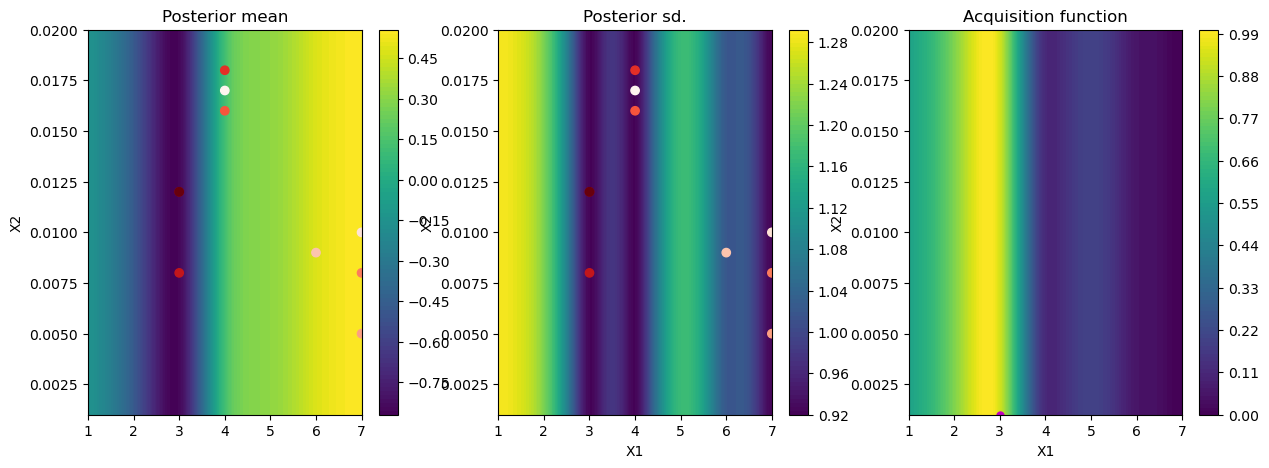

Epoch 1/10
2/2 [==============================] - 1s 407ms/step - loss: 2.1800 - accuracy: 0.1617 - val_loss: 1.6058 - val_accuracy: 0.4700
Epoch 2/10
2/2 [==============================] - 1s 311ms/step - loss: 1.5900 - accuracy: 0.4367 - val_loss: 1.0691 - val_accuracy: 0.6100
Epoch 3/10
2/2 [==============================] - 1s 308ms/step - loss: 1.2503 - accuracy: 0.5800 - val_loss: 0.8963 - val_accuracy: 0.6700
Epoch 4/10
2/2 [==============================] - 1s 335ms/step - loss: 1.0520 - accuracy: 0.6250 - val_loss: 0.8360 - val_accuracy: 0.7400
Epoch 5/10
2/2 [==============================] - 1s 342ms/step - loss: 0.9558 - accuracy: 0.6917 - val_loss: 0.6820 - val_accuracy: 0.7400
Epoch 6/10
2/2 [==============================] - 1s 371ms/step - loss: 0.8325 - accuracy: 0.7467 - val_loss: 0.6264 - val_accuracy: 0.8200
Epoch 7/10
2/2 [==============================] - 1s 343ms/step - loss: 0.7674 - accuracy: 0.7267 - val_loss: 0.5423 - val_accuracy: 0.7600
Epoch 8/10
2/2 [====

2/2 [==============================] - 1s 314ms/step - loss: 0.5498 - accuracy: 0.8133 - val_loss: 0.4107 - val_accuracy: 0.8500
Epoch 10/10
2/2 [==============================] - 1s 321ms/step - loss: 0.4568 - accuracy: 0.8283 - val_loss: 0.4835 - val_accuracy: 0.8400
Epoch 1/10
2/2 [==============================] - 1s 462ms/step - loss: 7.5256 - accuracy: 0.1283 - val_loss: 6.7766 - val_accuracy: 0.1600
Epoch 2/10
2/2 [==============================] - 1s 311ms/step - loss: 5.1928 - accuracy: 0.1667 - val_loss: 2.2585 - val_accuracy: 0.2700
Epoch 3/10
2/2 [==============================] - 1s 311ms/step - loss: 2.2600 - accuracy: 0.1800 - val_loss: 2.2052 - val_accuracy: 0.1500
Epoch 4/10
2/2 [==============================] - 1s 336ms/step - loss: 2.1717 - accuracy: 0.1883 - val_loss: 2.0224 - val_accuracy: 0.3400
Epoch 5/10
2/2 [==============================] - 1s 321ms/step - loss: 1.9963 - accuracy: 0.3100 - val_loss: 1.6753 - val_accuracy: 0.5700
Epoch 6/10
2/2 [==============

2/2 [==============================] - 1s 325ms/step - loss: 0.6668 - accuracy: 0.7550 - val_loss: 0.5759 - val_accuracy: 0.7700
Epoch 8/10
2/2 [==============================] - 1s 317ms/step - loss: 0.6184 - accuracy: 0.7733 - val_loss: 0.5862 - val_accuracy: 0.7800
Epoch 9/10
2/2 [==============================] - 1s 332ms/step - loss: 0.5277 - accuracy: 0.8200 - val_loss: 0.5803 - val_accuracy: 0.8000
Epoch 10/10
2/2 [==============================] - 1s 325ms/step - loss: 0.4532 - accuracy: 0.8300 - val_loss: 0.5639 - val_accuracy: 0.8100
Epoch 1/10
2/2 [==============================] - 1s 546ms/step - loss: 7.9930 - accuracy: 0.1017 - val_loss: 3.4815 - val_accuracy: 0.1700
Epoch 2/10
2/2 [==============================] - 1s 316ms/step - loss: 3.0422 - accuracy: 0.2050 - val_loss: 2.0977 - val_accuracy: 0.4100
Epoch 3/10
2/2 [==============================] - 1s 323ms/step - loss: 2.0441 - accuracy: 0.3350 - val_loss: 1.5744 - val_accuracy: 0.5700
Epoch 4/10
2/2 [==============

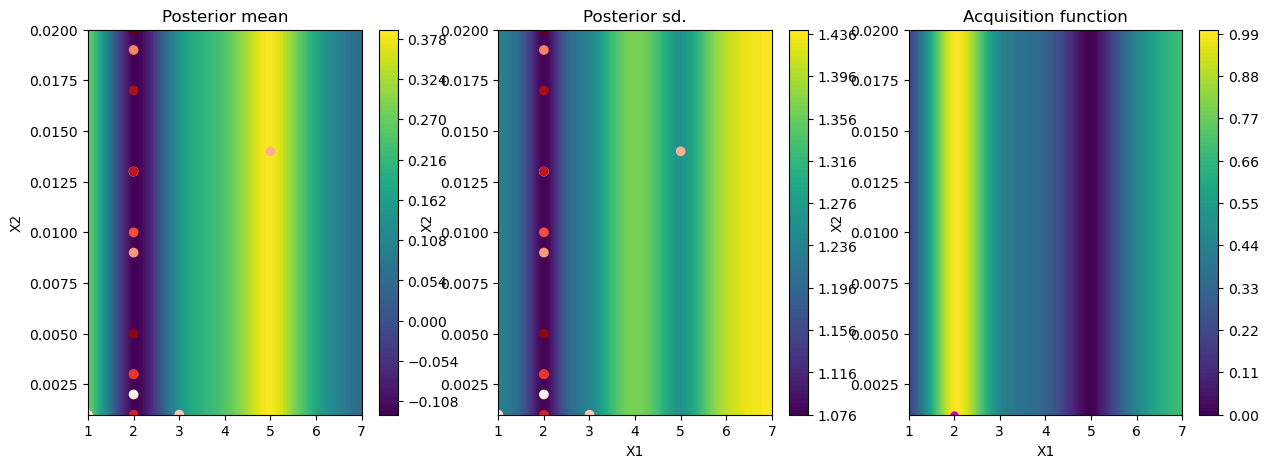

Epoch 1/10
2/2 [==============================] - 1s 413ms/step - loss: 2.2692 - accuracy: 0.1983 - val_loss: 1.6835 - val_accuracy: 0.5100
Epoch 2/10
2/2 [==============================] - 1s 300ms/step - loss: 1.7088 - accuracy: 0.4467 - val_loss: 1.0404 - val_accuracy: 0.7100
Epoch 3/10
2/2 [==============================] - 1s 305ms/step - loss: 1.1003 - accuracy: 0.6383 - val_loss: 0.6749 - val_accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 1s 313ms/step - loss: 0.9029 - accuracy: 0.6783 - val_loss: 0.5861 - val_accuracy: 0.8000
Epoch 5/10
2/2 [==============================] - 1s 307ms/step - loss: 0.7437 - accuracy: 0.7583 - val_loss: 0.5836 - val_accuracy: 0.7700
Epoch 6/10
2/2 [==============================] - 1s 317ms/step - loss: 0.6728 - accuracy: 0.7550 - val_loss: 0.5249 - val_accuracy: 0.8200
Epoch 7/10
2/2 [==============================] - 1s 300ms/step - loss: 0.5976 - accuracy: 0.8100 - val_loss: 0.4557 - val_accuracy: 0.8500
Epoch 8/10
2/2 [====

2/2 [==============================] - 1s 395ms/step - loss: 0.5980 - accuracy: 0.7783 - val_loss: 0.5233 - val_accuracy: 0.8200
Epoch 10/10
2/2 [==============================] - 1s 374ms/step - loss: 0.4888 - accuracy: 0.8350 - val_loss: 0.5205 - val_accuracy: 0.8300
Epoch 1/10
2/2 [==============================] - 1s 490ms/step - loss: 2.9137 - accuracy: 0.1517 - val_loss: 1.8572 - val_accuracy: 0.3900
Epoch 2/10
2/2 [==============================] - 1s 323ms/step - loss: 1.9917 - accuracy: 0.4200 - val_loss: 1.4657 - val_accuracy: 0.5600
Epoch 3/10
2/2 [==============================] - 1s 342ms/step - loss: 1.4174 - accuracy: 0.5350 - val_loss: 0.8166 - val_accuracy: 0.7000
Epoch 4/10
2/2 [==============================] - 1s 325ms/step - loss: 0.9996 - accuracy: 0.6567 - val_loss: 0.5908 - val_accuracy: 0.7600
Epoch 5/10
2/2 [==============================] - 1s 337ms/step - loss: 0.7626 - accuracy: 0.7317 - val_loss: 0.5414 - val_accuracy: 0.7900
Epoch 6/10
2/2 [==============

2/2 [==============================] - 1s 348ms/step - loss: 0.7019 - accuracy: 0.7583 - val_loss: 0.5284 - val_accuracy: 0.8200
Epoch 8/10
2/2 [==============================] - 1s 340ms/step - loss: 0.6014 - accuracy: 0.7983 - val_loss: 0.4864 - val_accuracy: 0.8200
Epoch 9/10
2/2 [==============================] - 1s 330ms/step - loss: 0.5543 - accuracy: 0.7917 - val_loss: 0.5243 - val_accuracy: 0.8200
Epoch 10/10
2/2 [==============================] - 1s 350ms/step - loss: 0.5474 - accuracy: 0.7933 - val_loss: 0.4889 - val_accuracy: 0.8300
Epoch 1/10
2/2 [==============================] - 1s 506ms/step - loss: 5.1496 - accuracy: 0.1467 - val_loss: 4.7930 - val_accuracy: 0.2300
Epoch 2/10
2/2 [==============================] - 1s 307ms/step - loss: 3.8832 - accuracy: 0.2717 - val_loss: 2.1417 - val_accuracy: 0.3700
Epoch 3/10
2/2 [==============================] - 1s 342ms/step - loss: 2.1003 - accuracy: 0.3650 - val_loss: 1.7573 - val_accuracy: 0.4600
Epoch 4/10
2/2 [==============

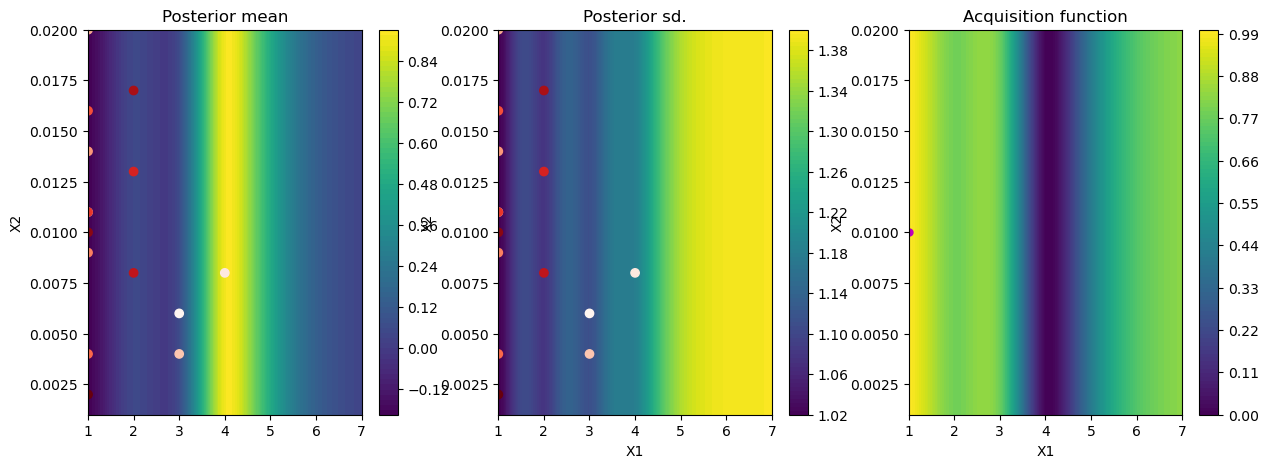

In [27]:
#### import GPy
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

# Same hyperparameters as before:
## Kernel sizes
kernel_sizes = tuple(np.arange(1,8,1, dtype = np.int64))
## Learning rate:
lr = tuple(np.arange(0.001, 0.0201, 0.001, dtype = np.float64))



domain = [{'name': 'kernel_sizes', 'type': 'discrete', 'domain': kernel_sizes},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': lr},
          ]

def objective_function(x):
    param = x[0]
    
    acc = CNN_Model_Train(kernel_size = param[0], learning_rate = param[1])
    
    return -float(acc)

k = GPy.kern.Matern32(1, variance=1, lengthscale=1, ARD=False)
k.variance.fix()
k.lengthscale.fix()
np.random.seed(5)

for acq in ["EI","MPI","LCB"]:
    #print("Acquistion used is:",acq)
    start = timer()
    ### EI acquisition function ###
    acquisition_func = acq

    opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                                  domain = domain,         # box-constrains of the problem
                                                  acquisition_type = acquisition_func,      # Select acquisition function MPI, EI, LCB
                                                  kernel=k   # set kernel
                                                 )
    opt.acquisition.exploration_weight=.1

    opt.run_optimization(max_iter = 10) 
    print(str(opt.model.get_model_parameters_names()))
    print(str(opt.model.get_model_parameters()))
    print(k)

    x_best = opt.X[np.argmin(opt.Y)]

    end = timer()
    print("For acquisition_type: {0}".format(acquisition_func))
    print("time: {0}".format(end - start))
    print("The best parameters obtained: {0}".format(x_best))
    print("The accuracy was: {0}".format(-min(opt.Y)))
    
    opt.plot_acquisition()